### Week 10 Lab Questions

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### 1. Implement Auto-Encoder for latent representation of MNIST dataset.

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder maps 784 -> 100 -> 10 (latent representation)
        self.Encoder = nn.Sequential(
            nn.Linear(784, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 10, bias=True),
            nn.Sigmoid(),  # Ensures latent values are between 0 and 1
        )
        # Decoder reconstructs the image from the latent vector
        self.Decoder = nn.Sequential(
            nn.BatchNorm1d(10),
            nn.Linear(10, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 784, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.Encoder(x)
        x_reconstructed = self.Decoder(latent)
        return latent, x_reconstructed.view(-1, 1, 28, 28)

def loss_function(x, x_hat):
    # Reconstruction loss only (binary cross entropy)
    return F.binary_cross_entropy(x_hat, x, reduction='sum')

# MNIST DataLoader
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set device, instantiate model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(epoch_index):
    model.train()
    total_loss = 0.0
    for i, data in enumerate(train_data_loader):
        inputs, _ = data
        inputs = inputs.to(device)
        # Flatten the input images to a 784-dimensional vector
        inputs_flat = inputs.view(inputs.size(0), -1)

        optimizer.zero_grad()
        latent, outputs = model(inputs_flat)
        loss = loss_function(inputs, outputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / (len(train_data_loader) * batch_size)

def generate_digit():
    model.eval()
    # Sample a random latent vector from a uniform distribution in [0,1]
    latent_sample = torch.rand((1, 10))
    x_decoded = model.Decoder(latent_sample.to(device))
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

# Example training loop
num_epochs = 10
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(epoch)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 168.84271999920355
Epoch 2, Loss: 123.28715734746156
Epoch 3, Loss: 115.57096251140017
Epoch 4, Loss: 112.33310876777178
Epoch 5, Loss: 110.20255762681778
Epoch 6, Loss: 108.71214728772259
Epoch 7, Loss: 107.40109370054721
Epoch 8, Loss: 106.47127627309706
Epoch 9, Loss: 105.63132172606902
Epoch 10, Loss: 104.94819367821538


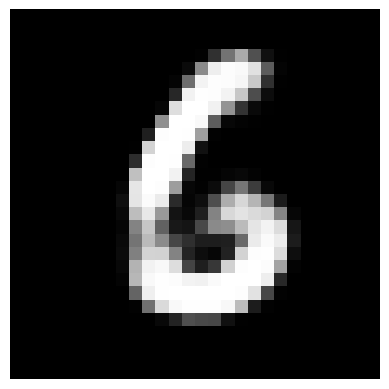

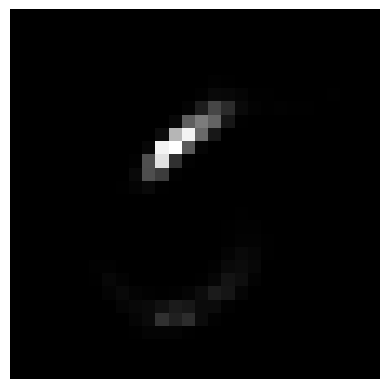

In [10]:
# Generate a reconstructed digit using a random latent vector
generate_digit()
generate_digit()

### 2. Implement VAE for synthesizing digits using MNIST training data.

In [11]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder maps 784 -> 100 -> 10
        self.Encoder = nn.Sequential(
            nn.Linear(784, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 10, bias=True),
            nn.Sigmoid(),
        )
        # Compute latent mean and log variance from the encoder output (10-dimensional)
        self.mean = nn.Linear(10, 10, bias=True)
        self.log_var = nn.Linear(10, 10, bias=True)

        self.Decoder = nn.Sequential(
            nn.BatchNorm1d(10),
            nn.Linear(10, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 784, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.Encoder(x)
        mean = self.mean(enc)
        log_var = self.log_var(enc)
        # Reparameterization trick
        z = mean + torch.exp(0.5 * log_var) * torch.randn_like(log_var)
        y = self.Decoder(z)
        return mean, log_var, y.view(-1, 1, 28, 28)

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# MNIST DataLoader
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set device, instantiate model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = loss_function

def train_one_epoch(epoch_index):
    model.train()
    total_loss = 0.0
    for i, data in enumerate(train_data_loader):
        inputs, _ = data
        inputs = inputs.to(device)
        # Flatten the input images to a 784-dimensional vector
        inputs_flat = inputs.view(inputs.size(0), -1)

        optimizer.zero_grad()
        mean, log_var, outputs = model(inputs_flat)
        loss = loss_fn(inputs, outputs, mean, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / (len(train_data_loader) * batch_size)

def generate_digit():
    model.eval()
    # Sample from a standard normal latent space
    mean = torch.zeros((1, 10))
    var = torch.ones((1, 10))
    z_sample = mean + var * torch.randn_like(var)
    x_decoded = model.Decoder(z_sample.to(device))
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

# Example training loop
num_epochs = 10
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(epoch)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 211.2582610888776
Epoch 2, Loss: 175.55275283846012
Epoch 3, Loss: 164.04321007637074
Epoch 4, Loss: 158.7026914584357
Epoch 5, Loss: 155.50068566946587
Epoch 6, Loss: 153.19169148199086
Epoch 7, Loss: 151.607382556777
Epoch 8, Loss: 150.46769584216543
Epoch 9, Loss: 149.44789149562942
Epoch 10, Loss: 148.78478252353952


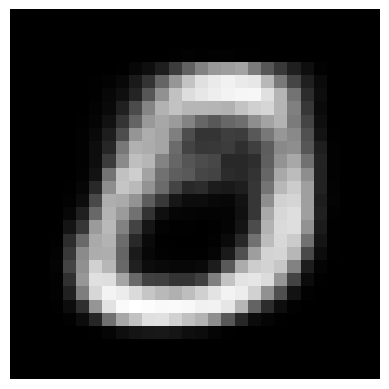

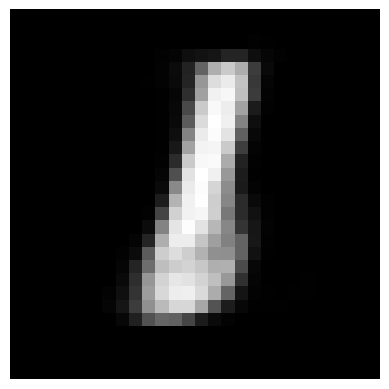

In [5]:
# Generate a synthesized digit after training
generate_digit()
generate_digit()